# Gene expression

Meta-analisys with gene expression.

## Gene expression during zebrafish development

Meta analysis combines the results of other studies. It requires raw data, already produced by others. The design is very important. Ex. you have a sample, coming from a tumor, and another, from healthy individual. The two samples contain all the sample from one tissue.

With RNASeq we measure the expression level of all the genes, obtaining a table that, for every gene (geneA, geneB..) , indicates all the relative expression in all the tissues (tumorIndividual1, tumorIndividual2, healthyIndividual1, healthyIndividual2...)

With microarray or sequencing we can measure the level of every gene in every sample. These can be correlated to causes, tumor development, or other things.

We can get several hundreds of candidates, showing significant differences, that we will focus on. This will lead to another table gene vs. significance of differences.

The gene list is not enough. With annotations, we can infer actions of the gene.

**Functional enrichment**: I want to understand not the function itself, but the pathway impact. 

We take many lists: upregulated, downregulated, etc. We take one or more metrics (overlap, distance, match, window) and we relate with annotations (GO, KEGG, OMIM, Repeats, Pseudogenes, Domains, Homologous...), looking for some enrichment.

In this way we can have functional interpretation of expression tables. **Enrichment Analysis** will tell us if a collection of gene is enriched for a particular function.

First, we isolated differentially expressed genes. We can classify genes for their involvement in metabolism, regulation of transcription, or signaling pathways... We take our DEG and check if the overlap with these classes is normal or not, to guess if the pathological state is relevant to metabolism, regulation, etc. and eventually subset your search area in the intersection of class and DEG. Then, studying enrichment, we can filter more and more, creating new hypotheses.



## Illumina HiSeq Analysis

Data comes from GEO (gene expression omnibus), at NCBI. For every experiment there is a series, and a lot of information. [link](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE105128).

The link contains the description of an experiment, its purpose, and other metadata. In this experiment, KAP1 gene is underexpressed / KO from mice. There are 6 samples, 3 deficient. On single sample pages, there is additional metadata, and a SRA link, that leads to the raw sequencing data. 

genecount.csv.gz is the raw count of processed data. after unzipping, we import it:



In [1]:
counts = read.csv(file = "GSE105128_genecount.csv")
head(counts)

geneName,WT1,WT2,WT3,KO1,KO2,KO3
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,2022,2141,2313,2311,2415,2748
ENSMUSG00000000003,0,0,0,0,0,0
ENSMUSG00000000028,157,128,97,98,112,145
ENSMUSG00000000031,0,0,0,0,0,0
ENSMUSG00000000037,5,5,8,7,10,8
ENSMUSG00000000049,0,0,0,0,0,2


Data are produced by extracting mRNA, and sequencing them. This produces a lot of small fragments of 15-150 bp. The fragments are stored in a FastQ file (a FASTA file with a quality value for all fragments) that evalutas the confidency of the sequencer in every single nucleotide with a single ascii code.

ENS before gene names indicates Ensembl files. Number are gene expression counts, that are the number of reads (fragments) that maps within the gene.

In [2]:
#load libraries:
library(edgeR)  #for differential expression normalization and filtering
library(org.Mm.eg.db) # annotation of mouse genome
library(tidyverse)

Loading required package: limma
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,


### Assigning groups for edgeR:
* 1 -> WT
* 2 -> KO

In [3]:


groups = factor (c(1,1,1,2,2,2))

# create edgeR proprietary data structure
data = DGEList(counts = counts[,2:7], 
                 group = groups,
                 genes = counts$geneName)

In [4]:
#perform a rough normalization, dividing by library size, and multiplying by 10^6.
cpm(data)  %>%
head() #count per million
CPM <- cpm(data)



WT1,WT2,WT3,KO1,KO2,KO3
200.1362550,210.3085367,224.5494594,229.2458367,242.607649,249.9375838
0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000
15.5397587,12.5733268,9.4169034,9.7213726,11.251369,13.1881185
0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000
0.4948968,0.4911456,0.7766518,0.6943838,1.004587,0.7276203
0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.1819051


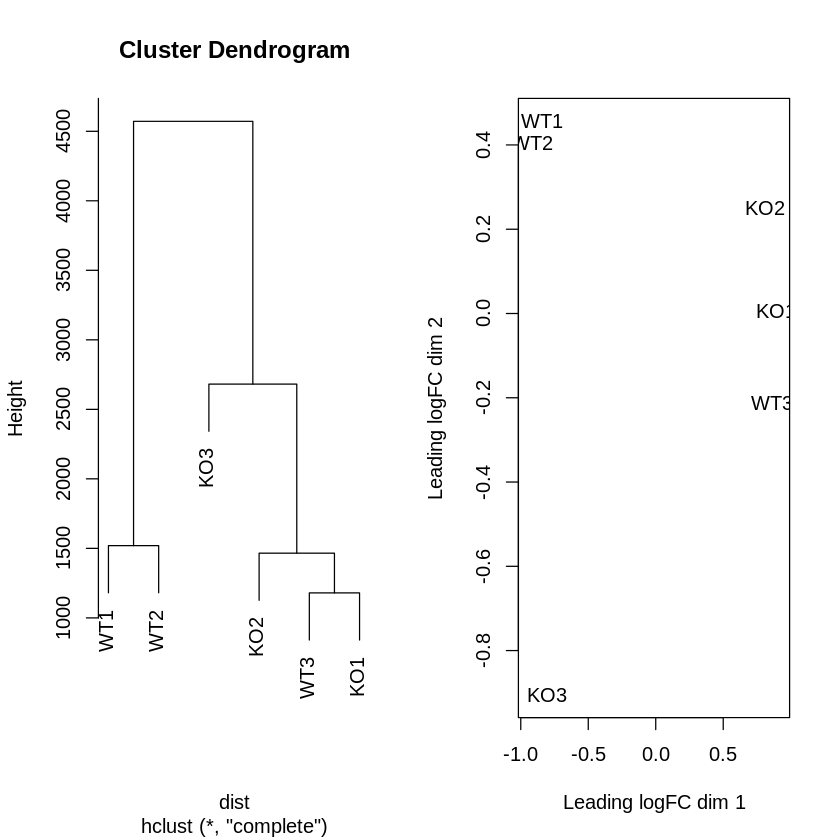

In [5]:
#calculate distance matrix between the experiments
dist <- dist(t(cpm(data)))

#clustering distance datas
hclust <- hclust(d = dist)

par(mfrow = c(1,2))
plot(hclust)
#multidimensional scaling plot, for same analysis
plotMDS(data)

In [98]:
# annotation, and looking for the KEP1 gene:
# maps from Ensembl ID and EntrezGene ID can be performed with

ens.eg <- as.list(org.Mm.egENSEMBL2EG) #ensembl-> EG
eg.sym <- as.list(org.Mm.egSYMBOL)   #gene Symbols -> EG

# head(ens.eg)
# head(eg.sym)

In [7]:
sum(eg.sym == "Kap1")

#There is no Kap1! Google search find many alias names, and Kap1 is an alias for TRIM28

[1] 0

In [8]:
sum(eg.sym == "Trim28")
#Here it is!

[1] 1

In [9]:
eg.sym[eg.sym=="Trim28"]  #... we find the Entrez Gene ID number...

$`21849`
[1] "Trim28"

In [10]:
ens.eg[ens.eg == names(eg.sym[eg.sym == "Trim28"])] #...and finally the Ensemble ID.

$ENSMUSG00000005566
[1] "21849"

In [11]:
kap1 = "ENSMUSG00000005566"

In [12]:
# create a CPM dataframe, attach gene names
CPM <- as.data.frame(CPM)
CPM$genes = counts$geneName

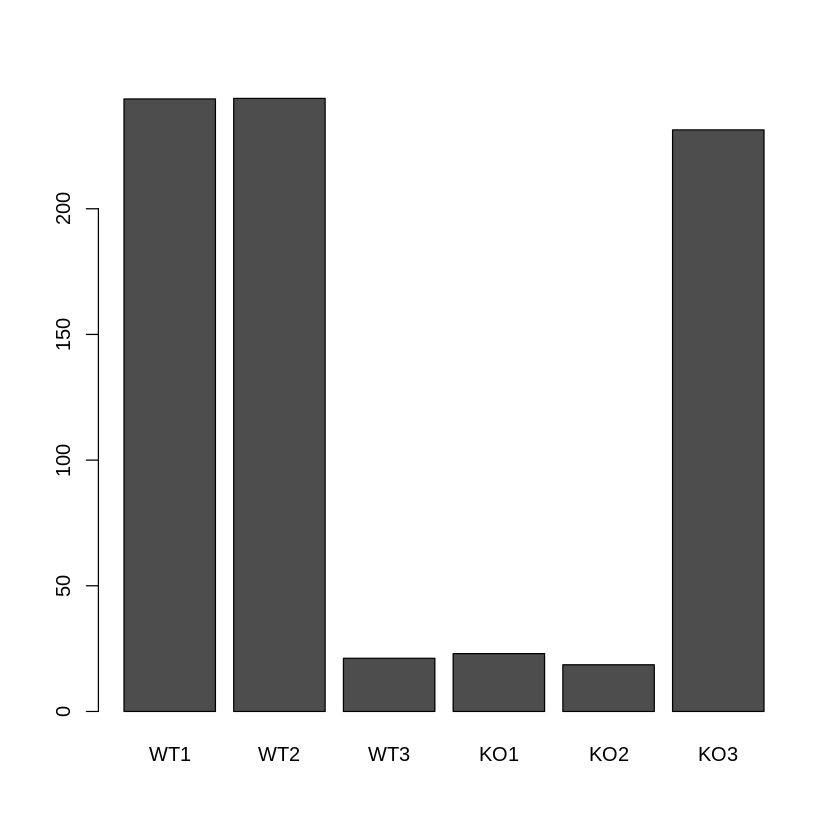

In [13]:
barplot(as.matrix((CPM[CPM$genes == kap1,1:6])))

In [44]:
#So, let's fix data.

groups2 = factor (c(1,1,2,2,2,1))  # new groups!

# create edgeR proprietary data structure
# with the same function

data2 = DGEList(counts = counts[,2:7], 
                 group = groups2,
                 genes = counts$geneName)

#perform a rough normalization, dividing by library size, and multiplying by 10^6.
#cpm(data2)

CPM2 <- cpm(data2)


Normalization. We add a `norm.factor` to the sample field of our DGE List.

In [45]:
data2 <- calcNormFactors(data2)


Create a design matrix, to state the groups of the study, in a contrast object.

In [46]:
design = model.matrix(~groups2)
design

(Intercept),groups22
1,0
1,0
1,1
1,1
1,1
1,0


Estimate the dispersion: an edgeR function to build the linear models to calculate the fold-change. Variability is higher for less dispersed data. It will use different corrections on different data, to make it less stringent. The aim is to calculate the fold-change. All info are attached to the dataset.

In [48]:
data2 <- estimateDisp(data2, design)

In [52]:
names(data2) # attached informations

[1] "counts"             "samples"            "genes"             
 [4] "design"             "common.dispersion"  "trended.dispersion"
 [7] "tagwise.dispersion" "AveLogCPM"          "trend.method"      
[10] "prior.df"           "prior.n"            "span"

We then apply a GLM.

In [55]:
fit <- glmQLFit(data2, design) # fitting the model
qlf <- glmQLFTest(fit, coef=2) # statistical test

topTags will show us the result of the fitting ina DGEGLM object.

In [56]:
topTags(qlf)

,genes,logFC,logCPM,F,PValue,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15325,ENSMUSG00000051726,5.339874,6.756629,2950.7837,3.347345e-55,1.271690e-50
5260,ENSMUSG00000025885,10.329885,6.489680,2811.8579,1.512093e-54,2.872295e-50
870,ENSMUSG00000005566,-3.509059,7.027317,2068.2475,2.151825e-50,2.725000e-46
7928,ENSMUSG00000030553,3.109103,7.105370,1824.6874,1.039514e-48,9.873045e-45
341,ENSMUSG00000001918,-2.212505,8.034318,1233.4925,1.699502e-43,1.291316e-39
7575,ENSMUSG00000029833,2.149791,7.883337,986.8285,1.442083e-40,9.131027e-37
16665,ENSMUSG00000057409,1.851938,7.642062,852.0912,1.162126e-38,6.307192e-35
2009,ENSMUSG00000018800,4.312535,4.397721,847.9831,1.341827e-38,6.372171e-35
12833,ENSMUSG00000043008,1.837532,9.162491,737.9876,8.195244e-37,3.459395e-33


Other statistical test:

In [59]:
lrt <- glmLRT(fit) # linearized test, RTFM.


In [77]:
ttags <- topTags(lrt) # gene per gene FoldChange - CountsPerMillion - LR(?) - PValue significance

logFC,logCPM,LR,PValue
<dbl>,<dbl>,<dbl>,<dbl>
0.08391315,7.82228700,1.15595495,0.28230603
0.00000000,-2.36036622,0.00000000,1.00000000
-0.43466295,3.60282180,8.65897671,0.00325454
0.00000000,-2.36036622,0.00000000,1.00000000
0.51851573,-0.16393952,1.18182164,0.27698546
-2.63949888,-2.13814483,2.67613590,0.10186262
0.15030713,5.69506634,2.43826616,0.11840704
-0.59111915,-1.30162539,0.55504035,0.45626549
0.03963565,7.50885530,0.25333084,0.61473944


In [82]:
max(ttags$table$FDR)

[1] 4.779696e-138

In [92]:
dim(topTags(lrt, p.value = 0.05, n=999999999))
res <- topTags(lrt, p.value = 0.05, n=999999999)

[1] 1024    6

In [96]:
res$table

,genes,logFC,logCPM,LR,PValue,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5260,ENSMUSG00000025885,10.329885,6.489680,2639.7591,0.000000e+00,0.000000e+00
15325,ENSMUSG00000051726,5.339874,6.756629,2135.3697,0.000000e+00,0.000000e+00
870,ENSMUSG00000005566,-3.509059,7.027317,1385.2840,3.313289e-303,4.195839e-299
7928,ENSMUSG00000030553,3.109103,7.105370,1179.3873,1.840963e-258,1.748501e-254
956,ENSMUSG00000006154,-5.872378,4.924604,1050.5702,1.829721e-230,1.390259e-226
341,ENSMUSG00000001918,-2.212505,8.034318,724.6855,1.281788e-159,8.116068e-156
7575,ENSMUSG00000029833,2.149791,7.883337,681.8709,2.618574e-150,1.421175e-146
2009,ENSMUSG00000018800,4.312535,4.397721,668.1751,2.491506e-147,1.183185e-143
9792,ENSMUSG00000034634,4.909676,4.092185,649.8178,2.447585e-143,1.033180e-139


In [101]:
#attach the Entrez Gene ID name

res.tab <- res$table
res.tab$eg =   apply(res.tab, 1, function(x) as.character(ens.eg[x[1]]))
res.tab$symb = apply(res.tab, 1, function(x) as.character(eg.sym[x[7]]))

In [102]:
head(res.tab)

,genes,logFC,logCPM,LR,PValue,FDR,eg,symb
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
5260,ENSMUSG00000025885,10.329885,6.489680,2639.7591,0.000000e+00,0.000000e+00,17919,Myo5b
15325,ENSMUSG00000051726,5.339874,6.756629,2135.3697,0.000000e+00,0.000000e+00,382571,Kcnf1
870,ENSMUSG00000005566,-3.509059,7.027317,1385.2840,3.313289e-303,4.195839e-299,21849,Trim28
7928,ENSMUSG00000030553,3.109103,7.105370,1179.3873,1.840963e-258,1.748501e-254,78444,Pgpep1l
956,ENSMUSG00000006154,-5.872378,4.924604,1050.5702,1.829721e-230,1.390259e-226,67425,Eps8l1
341,ENSMUSG00000001918,-2.212505,8.034318,724.6855,1.281788e-159,8.116068e-156,20514,Slc1a5


Trim28 is the most significant among those with a negative logFC. 

In [105]:
plot.gene = function (x){
    id = names(ens.eg[ens.eg==names(eg.sym[(eg.sym==x)])])
    if(length(id)==1) barplot(data[data$genes==id,]$counts, main=x)
}

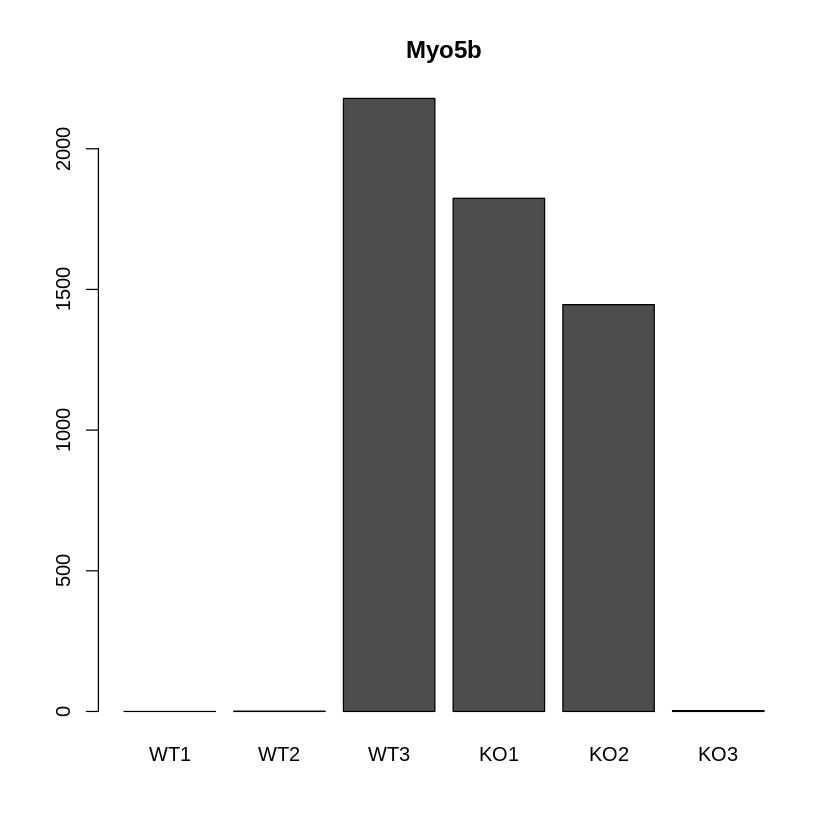

In [106]:
plot.gene("Myo5b")